In [10]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# **X-ray Chest Classification**

## **Deep Learning Model for Chest X-ray Classification**

This notebook implements a convolutional neural network (CNN) to classify chest X-ray images into three categories:
- Normal
- COVID-19
- Pneumonia

**Dataset Source**: [COVID Pneumonia Normal Chest X-ray Images](https://www.kaggle.com/datasets/sachinkumar413/covid-pneumonia-normal-chest-xray-images)


In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
from utils import train_one_epoch, evaluate, get_device, set_seed, save_experiment_json, plot_history, performance, save_checkpoint, EarlyStopping
import torchsummary
set_seed(42)

In [40]:
CLASSES = ['COVID', 'NORMAL', 'PNEUMONIA']

In [6]:
project_root = os.getcwd()
BASE_DIR = os.path.basename(project_root)
DEVICE = get_device()
print("base dir:", BASE_DIR)
print('  device:', DEVICE)

base dir: xray_chest_classification
  device: cuda


# 1. **Dataset Loading**

In [7]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for class_name in CLASSES:
            class_path = os.path.join(data_dir, class_name)
            for image in os.listdir(class_path):
                self.images.append(os.path.join(class_path, image))
                self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        img = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        y = CLASSES.index(label)
        transformed_image = self.transform(img)
        original_image = torch.tensor(cv2.resize(np.asarray(img), (224, 224)))

        return original_image, transformed_image, torch.tensor(y)

In [8]:
train_dir = os.path.join(project_root,"data/train")
val_dir = os.path.join(project_root,"data/val")
test_dir = os.path.join(project_root,"data/test")

BATCH_SIZE = 32

train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

eval_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_dataset = ChestXrayDataset(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

val_dataset = ChestXrayDataset(val_dir, transform=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True  )

test_dataset = ChestXrayDataset(test_dir,transform=eval_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print("Train loader size: ", len(train_loader))
print("Train loader size: ", len(val_loader))
print("Train loader size: ", len(test_loader))

Train loader size:  131
Train loader size:  17
Train loader size:  17


In [9]:
original_img, inputs, labels = next(iter(train_loader))

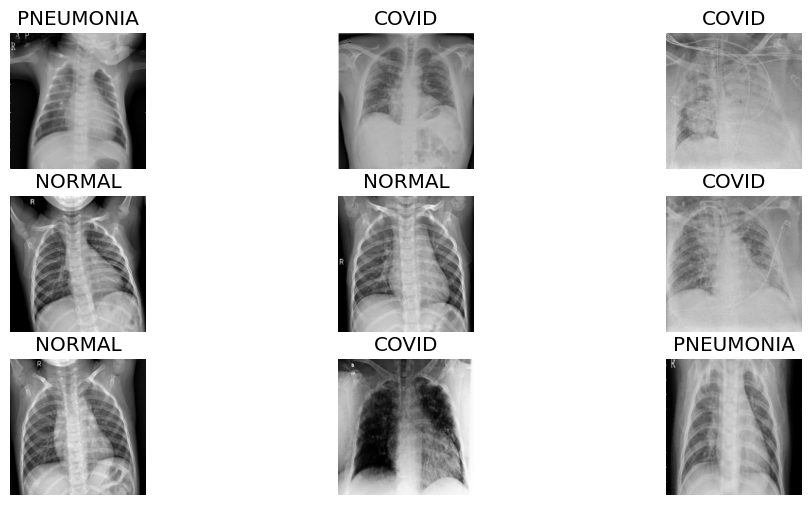

In [11]:
plt.figure(figsize=(12, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(
        original_img[i].cpu().detach().numpy().reshape(224, 224, 3).astype("uint8")
    )
    plt.title(f"{CLASSES[labels[i]]}")
    plt.axis("off")

# **2. Baseline Model**

In [13]:
from model import BaselineCNN
baseline_model = BaselineCNN(num_classes=len(CLASSES)).to(DEVICE)
torchsummary.summary(baseline_model, (3, 224, 224), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 224, 224]             896
              ReLU-2         [32, 32, 224, 224]               0
         MaxPool2d-3         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-4             [32, 32, 4, 4]               0
           Flatten-5                  [32, 512]               0
            Linear-6                    [32, 3]           1,539
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 18.38
Forward/backward pass size (MB): 882.25
Params size (MB): 0.01
Estimated Total Size (MB): 900.64
----------------------------------------------------------------


In [31]:
NUM_EPOCHS = 30
LR = 1e-3
PATIENCE = 5
MODEL_NAME = "BaselineModel"

In [15]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_recall": [],
    "val_auc": [],
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

In [16]:
baseline_model = baseline_model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=baseline_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [20]:
MODEL_SAVED_PATH = f"{project_root}/model_checkpoints/best_{MODEL_NAME}.pth"
history['MODEL_SAVED_PATH'] = MODEL_SAVED_PATH
early_stopping = EarlyStopping(
    model_checkpoint=MODEL_SAVED_PATH, patience=PATIENCE, mode='max')

In [21]:
for epoch in range(NUM_EPOCHS):
    # Train & Evaluate
    train_loss, train_acc = train_one_epoch(baseline_model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc = evaluate(baseline_model, val_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{NUM_EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Metrics record
    history['train_losses'].append(train_loss)
    history['val_losses'].append(valid_loss)
    history['train_accuracy'].append(train_acc)
    history['val_accuracy'].append(valid_acc)
    
    should_stop, best_score, best_epoch = early_stopping.should_stop(
        baseline_model, optimizer=optimizer, epoch=epoch, score=valid_acc)
    if should_stop:
        print(f"[Early Stopping]: Stop at epoch {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}")
        
    history['best_accuracy'] = best_score
    history['best_epoch'] = best_epoch
    
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.80it/s]


[1/30] train_acc: 0.7374 - train_loss: 0.6783 - valid_acc: 0.8298 - valid_loss: 0.4851
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 1 - acc: 0.8298



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  8.05it/s]


[2/30] train_acc: 0.7319 - train_loss: 0.6826 - valid_acc: 0.7648 - valid_loss: 0.5423
	- [current best] epoch: 1 - acc: 0.8298



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


[3/30] train_acc: 0.7367 - train_loss: 0.6778 - valid_acc: 0.8413 - valid_loss: 0.4691
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 3 - acc: 0.8413



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.39it/s]


[4/30] train_acc: 0.7429 - train_loss: 0.6491 - valid_acc: 0.8413 - valid_loss: 0.4620
	- [current best] epoch: 3 - acc: 0.8413



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


[5/30] train_acc: 0.7460 - train_loss: 0.6508 - valid_acc: 0.8222 - valid_loss: 0.4651
	- [current best] epoch: 3 - acc: 0.8413



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


[6/30] train_acc: 0.7467 - train_loss: 0.6598 - valid_acc: 0.8279 - valid_loss: 0.4711
	- [current best] epoch: 3 - acc: 0.8413



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.78it/s]


[7/30] train_acc: 0.7481 - train_loss: 0.6600 - valid_acc: 0.8279 - valid_loss: 0.4751
	- [current best] epoch: 3 - acc: 0.8413



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.40it/s]


[8/30] train_acc: 0.7441 - train_loss: 0.6558 - valid_acc: 0.8317 - valid_loss: 0.4802
[Early Stopping]: Stop at epoch 8 - Best epoch: 3 - Best score: 0.8413001912045889
	- [current best] epoch: 3 - acc: 0.8413



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.05it/s]


[9/30] train_acc: 0.7486 - train_loss: 0.6383 - valid_acc: 0.8509 - valid_loss: 0.4406
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 9 - acc: 0.8509



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.95it/s]


[10/30] train_acc: 0.7474 - train_loss: 0.6410 - valid_acc: 0.8356 - valid_loss: 0.4733
	- [current best] epoch: 9 - acc: 0.8509



Evaluating: 100%|██████████| 17/17 [00:04<00:00,  4.19it/s]


[11/30] train_acc: 0.7522 - train_loss: 0.6331 - valid_acc: 0.8126 - valid_loss: 0.4982
	- [current best] epoch: 9 - acc: 0.8509



Evaluating: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


[12/30] train_acc: 0.7568 - train_loss: 0.6288 - valid_acc: 0.8203 - valid_loss: 0.4771
	- [current best] epoch: 9 - acc: 0.8509



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.35it/s]


[13/30] train_acc: 0.7532 - train_loss: 0.6322 - valid_acc: 0.8757 - valid_loss: 0.4051
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.63it/s]


[14/30] train_acc: 0.7553 - train_loss: 0.6360 - valid_acc: 0.8681 - valid_loss: 0.3915
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.29it/s]


[15/30] train_acc: 0.7685 - train_loss: 0.6130 - valid_acc: 0.8470 - valid_loss: 0.4291
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.13it/s]


[16/30] train_acc: 0.7546 - train_loss: 0.6251 - valid_acc: 0.8432 - valid_loss: 0.4356
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.82it/s]


[17/30] train_acc: 0.7601 - train_loss: 0.6071 - valid_acc: 0.8700 - valid_loss: 0.3895
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:03<00:00,  5.66it/s]


[18/30] train_acc: 0.7690 - train_loss: 0.5872 - valid_acc: 0.8642 - valid_loss: 0.4040
[Early Stopping]: Stop at epoch 18 - Best epoch: 13 - Best score: 0.875717017208413
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:04<00:00,  4.11it/s]


[19/30] train_acc: 0.7685 - train_loss: 0.6145 - valid_acc: 0.8547 - valid_loss: 0.4154
[Early Stopping]: Stop at epoch 19 - Best epoch: 13 - Best score: 0.875717017208413
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]


[20/30] train_acc: 0.7620 - train_loss: 0.6144 - valid_acc: 0.8757 - valid_loss: 0.3664
[Early Stopping]: Stop at epoch 20 - Best epoch: 13 - Best score: 0.875717017208413
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  5.84it/s]


[21/30] train_acc: 0.7778 - train_loss: 0.5858 - valid_acc: 0.8662 - valid_loss: 0.3942
[Early Stopping]: Stop at epoch 21 - Best epoch: 13 - Best score: 0.875717017208413
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  5.75it/s]


[22/30] train_acc: 0.7678 - train_loss: 0.5957 - valid_acc: 0.8681 - valid_loss: 0.4088
[Early Stopping]: Stop at epoch 22 - Best epoch: 13 - Best score: 0.875717017208413
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  8.23it/s]


[23/30] train_acc: 0.7835 - train_loss: 0.5828 - valid_acc: 0.8642 - valid_loss: 0.4155
[Early Stopping]: Stop at epoch 23 - Best epoch: 13 - Best score: 0.875717017208413
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


[24/30] train_acc: 0.7678 - train_loss: 0.5969 - valid_acc: 0.8738 - valid_loss: 0.3806
[Early Stopping]: Stop at epoch 24 - Best epoch: 13 - Best score: 0.875717017208413
	- [current best] epoch: 13 - acc: 0.8757



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


[25/30] train_acc: 0.7697 - train_loss: 0.6030 - valid_acc: 0.8948 - valid_loss: 0.3545
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 25 - acc: 0.8948



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


[26/30] train_acc: 0.7658 - train_loss: 0.5905 - valid_acc: 0.8719 - valid_loss: 0.3730
	- [current best] epoch: 25 - acc: 0.8948



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  8.25it/s]


[27/30] train_acc: 0.7728 - train_loss: 0.5950 - valid_acc: 0.8967 - valid_loss: 0.3361
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 27 - acc: 0.8967



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


[28/30] train_acc: 0.7627 - train_loss: 0.5982 - valid_acc: 0.8681 - valid_loss: 0.3790
	- [current best] epoch: 27 - acc: 0.8967



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


[29/30] train_acc: 0.7675 - train_loss: 0.5938 - valid_acc: 0.8738 - valid_loss: 0.3845
	- [current best] epoch: 27 - acc: 0.8967



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]

[30/30] train_acc: 0.7764 - train_loss: 0.5856 - valid_acc: 0.8853 - valid_loss: 0.3622
	- [current best] epoch: 27 - acc: 0.8967



In [22]:
MODEL_SAVED = f"{project_root}/model_checkpoints/{MODEL_NAME}_model_weights.pth"
save_checkpoint(baseline_model, optimizer, MODEL_SAVED)

Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/BaselineModel_model_weights.pth


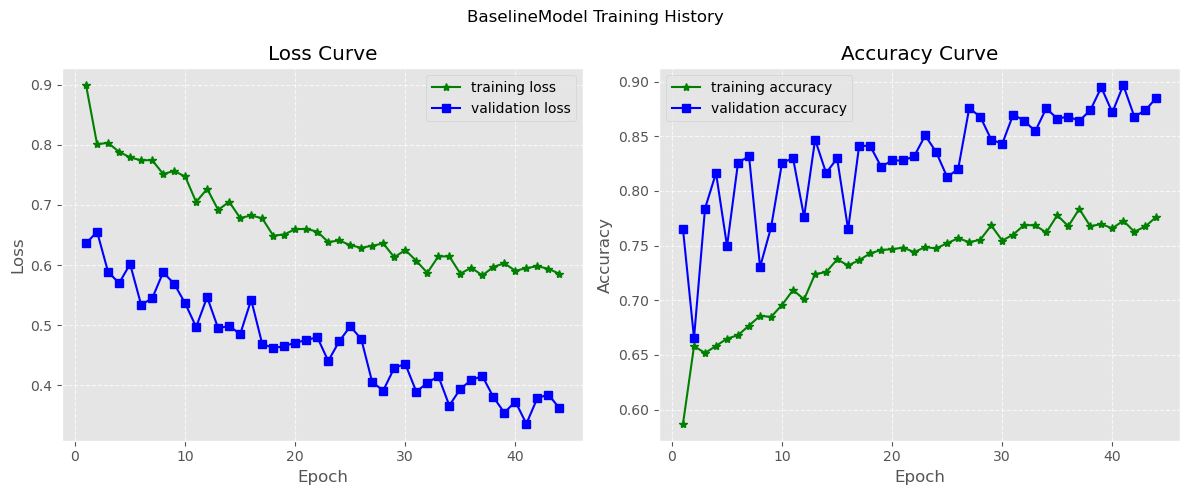

In [25]:
SAVE_PATH = f"{project_root}/results/{MODEL_NAME}"
plot_history(
    history,
    title=f"{MODEL_NAME} Training History",
    save_path=f"{SAVE_PATH}.png")

Getting predictions: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


Accuracy score: 0.8817
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       163
           1       0.81      0.96      0.88       181
           2       0.94      0.82      0.88       180

    accuracy                           0.88       524
   macro avg       0.89      0.88      0.88       524
weighted avg       0.89      0.88      0.88       524



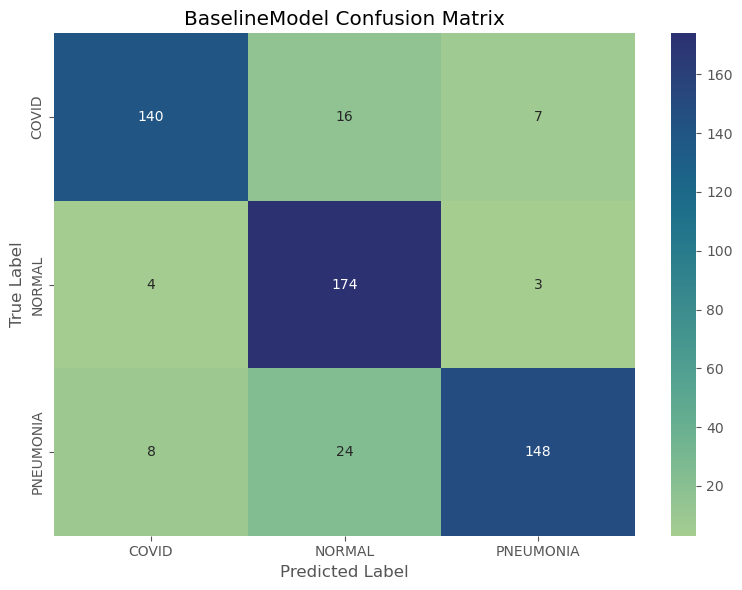

In [32]:
SAVE_PATH = f"{project_root}/results/{MODEL_NAME}_cfm.png"
performance(baseline_model, test_loader, DEVICE, MODEL_NAME, class_names=CLASSES, save_path=SAVE_PATH)

# **3. Reference Model: EfficientNet (Transfer Learning)**



In [91]:
from model import SimpleEfficientNet

In [92]:
EPOCHS_STAGE_1 = 10  
LR_STAGE_1 = 1e-3  
EPOCHS_STAGE_2 = 20  
LR_STAGE_2 = 1e-5  
MODEL_NAME = "SimpleEfficientNet"

In [93]:
model = SimpleEfficientNet(num_classes=len(CLASSES)).to(DEVICE)
torchsummary.summary(model, (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [94]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_recall": [],
    "val_auc": [],
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

### 3.1 Train head-only

In [95]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_1)
criterion = nn.CrossEntropyLoss()

In [96]:
MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}.pth")
f"{project_root}/model_checkpoints/{MODEL_NAME}.pth"
history["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH
early_stopping = EarlyStopping(model_checkpoint=MODEL_SAVED_PATH, patience=PATIENCE, mode="max")

In [97]:
print(
    f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}"
)

for epoch in range(EPOCHS_STAGE_1):
    # # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)

    should_stop, best_score, best_epoch = early_stopping.should_stop(
        model, optimizer=optimizer, epoch=epoch, score=valid_acc
    )
    if should_stop:
        print(f"Early stopping: Stop at epoch: {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}")
        break

    history["best_accuracy"] = best_score
    history["best_epoch"] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.36it/s]


[1/10] train_acc: 0.7953 - train_loss: 0.5687 - valid_acc: 0.8948 - valid_loss: 0.2989
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 1 - acc: 0.8948



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


[2/10] train_acc: 0.8548 - train_loss: 0.3938 - valid_acc: 0.8795 - valid_loss: 0.2650
	- [current best] epoch: 1 - acc: 0.8948



Evaluating: 100%|██████████| 17/17 [00:03<00:00,  5.49it/s]


[3/10] train_acc: 0.8711 - train_loss: 0.3508 - valid_acc: 0.9140 - valid_loss: 0.2274
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 3 - acc: 0.9140



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.40it/s]


[4/10] train_acc: 0.8718 - train_loss: 0.3344 - valid_acc: 0.9197 - valid_loss: 0.2123
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 4 - acc: 0.9197



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


[5/10] train_acc: 0.8830 - train_loss: 0.3203 - valid_acc: 0.9159 - valid_loss: 0.1981
	- [current best] epoch: 4 - acc: 0.9197



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.26it/s]


[6/10] train_acc: 0.8814 - train_loss: 0.3200 - valid_acc: 0.9159 - valid_loss: 0.2227
	- [current best] epoch: 4 - acc: 0.9197



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  5.90it/s]


[7/10] train_acc: 0.8921 - train_loss: 0.2980 - valid_acc: 0.9063 - valid_loss: 0.2046
	- [current best] epoch: 4 - acc: 0.9197



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.38it/s]


[8/10] train_acc: 0.8773 - train_loss: 0.3197 - valid_acc: 0.9216 - valid_loss: 0.1948
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 8 - acc: 0.9216



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.30it/s]


[9/10] train_acc: 0.8799 - train_loss: 0.3233 - valid_acc: 0.9082 - valid_loss: 0.2125
	- [current best] epoch: 8 - acc: 0.9216



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.11it/s]

[10/10] train_acc: 0.8876 - train_loss: 0.2969 - valid_acc: 0.9082 - valid_loss: 0.1963
	- [current best] epoch: 8 - acc: 0.9216



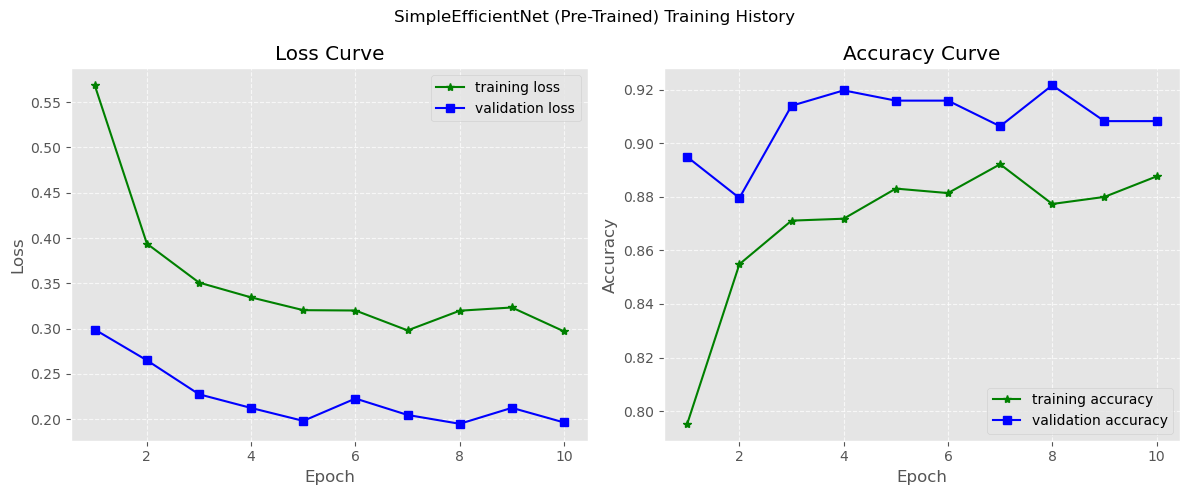

In [98]:
plot_history(history, f"{MODEL_NAME} (Pre-Trained) Training History")

In [99]:
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 17/17 [00:02<00:00,  6.11it/s]


Accuracy score: 0.9427
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       163
           1       0.91      0.93      0.92       181
           2       0.94      0.93      0.94       180

    accuracy                           0.94       524
   macro avg       0.94      0.94      0.94       524
weighted avg       0.94      0.94      0.94       524



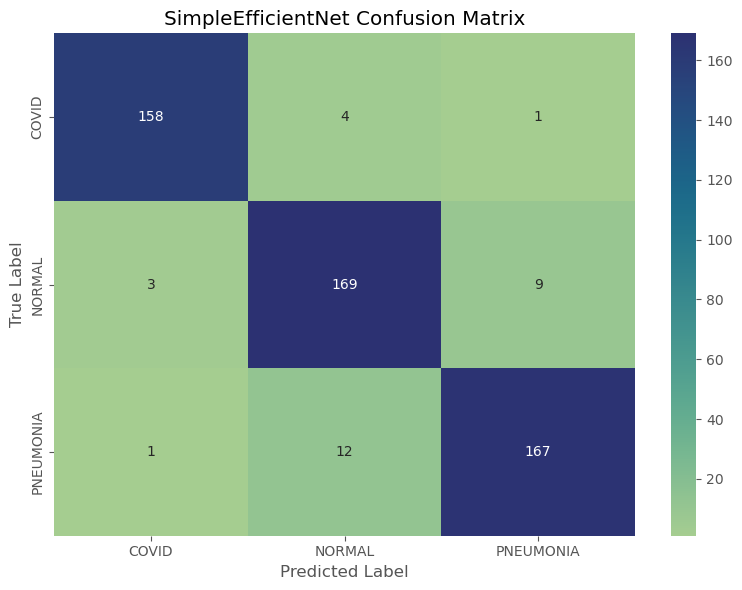

In [100]:
save_path = f"{project_root}/results/{MODEL_NAME}_cfm.png"
performance(model, test_loader, DEVICE, MODEL_NAME,class_names=CLASSES, save_path=save_path)

In [101]:
# Save history
json_path = os.path.join(
    project_root,
    f"results/{MODEL_NAME}_history.json",
)
save_experiment_json(history, json_path)

History saved to d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\results/SimpleEfficientNet_history.json


## **3.2. Fine-Tuning**

In [102]:
params = list(model.parameters())
print("Number of layers: ", len(params))

Number of layers:  213


In [103]:
for param in params:
    param.requires_grad = True
torchsummary.summary(model.to(DEVICE), (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [104]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_2)
criterion = nn.CrossEntropyLoss()
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_finetuned.pth"
new_early_stopping = EarlyStopping(model_checkpoint=model_save_path, patience=PATIENCE)

In [105]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2


print(
    f"Training configuration for stage 2: LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}"
)
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )

    should_stop, best_score, best_epoch = new_early_stopping.should_stop(
        model, optimizer=optimizer, epoch=epoch, score=valid_acc
    )
    if should_stop:
        print(
            f"Early stopping: Stop at epoch: {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}"
        )
        break
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["best_accuracy"] = best_score
    history["best_epoch"] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Training configuration for stage 2: LR = 1e-05, EPOCHS = 20


Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.21it/s]


[11/30 (Fine-Tune)] train_acc: 0.8972 - train_loss: 0.2778 - valid_acc: 0.9293 - valid_loss: 0.2023
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_SimpleEfficientNet_finetuned.pth
	- [current best] epoch: 11 - acc: 0.9293



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


[12/30 (Fine-Tune)] train_acc: 0.9029 - train_loss: 0.2623 - valid_acc: 0.9235 - valid_loss: 0.1838
	- [current best] epoch: 11 - acc: 0.9293



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.09it/s]


[13/30 (Fine-Tune)] train_acc: 0.9151 - train_loss: 0.2298 - valid_acc: 0.9350 - valid_loss: 0.1687
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_SimpleEfficientNet_finetuned.pth
	- [current best] epoch: 13 - acc: 0.9350



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


[14/30 (Fine-Tune)] train_acc: 0.9151 - train_loss: 0.2295 - valid_acc: 0.9273 - valid_loss: 0.1598
	- [current best] epoch: 13 - acc: 0.9350



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.31it/s]


[15/30 (Fine-Tune)] train_acc: 0.9175 - train_loss: 0.2162 - valid_acc: 0.9350 - valid_loss: 0.1548
	- [current best] epoch: 13 - acc: 0.9350



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.38it/s]


[16/30 (Fine-Tune)] train_acc: 0.9251 - train_loss: 0.2029 - valid_acc: 0.9273 - valid_loss: 0.1621
	- [current best] epoch: 13 - acc: 0.9350



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


[17/30 (Fine-Tune)] train_acc: 0.9273 - train_loss: 0.1980 - valid_acc: 0.9293 - valid_loss: 0.1515
	- [current best] epoch: 13 - acc: 0.9350



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.22it/s]

[18/30 (Fine-Tune)] train_acc: 0.9302 - train_loss: 0.1872 - valid_acc: 0.9331 - valid_loss: 0.1594
Early stopping: Stop at epoch: 18 - Best epoch: 13 - Best score: 0.9349904397705545


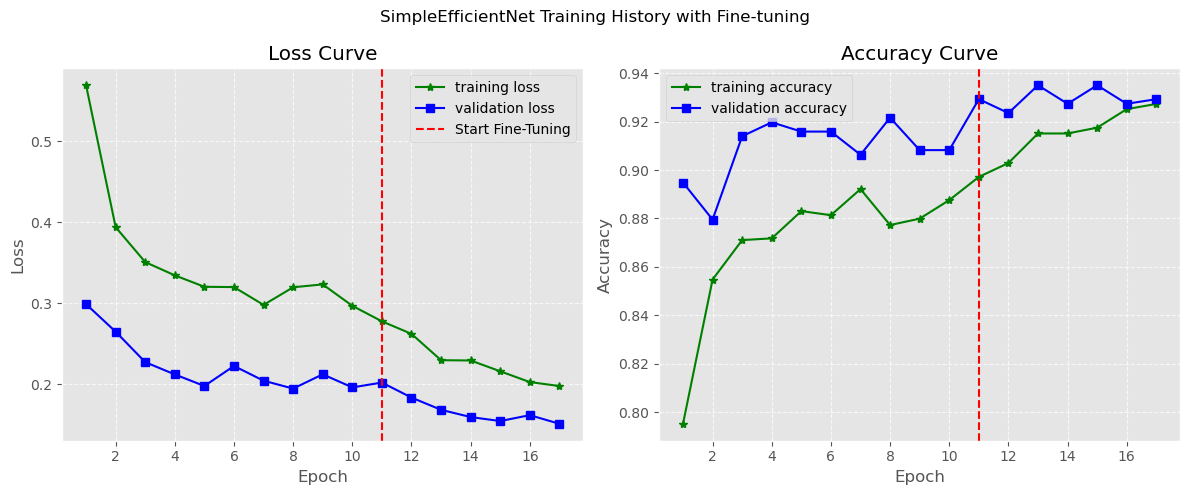

In [106]:
model_saved_name = (
    f"{project_root}/results/{MODEL_NAME}_finetuned"
)
plot_history(
    history,
    f"{MODEL_NAME} Training History with Fine-tuning",
    f"{model_saved_name}.png",
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1,
)

In [107]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 17/17 [00:02<00:00,  5.74it/s]


Accuracy score: 0.9504
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       163
           1       0.91      0.96      0.93       181
           2       0.95      0.93      0.94       180

    accuracy                           0.95       524
   macro avg       0.95      0.95      0.95       524
weighted avg       0.95      0.95      0.95       524



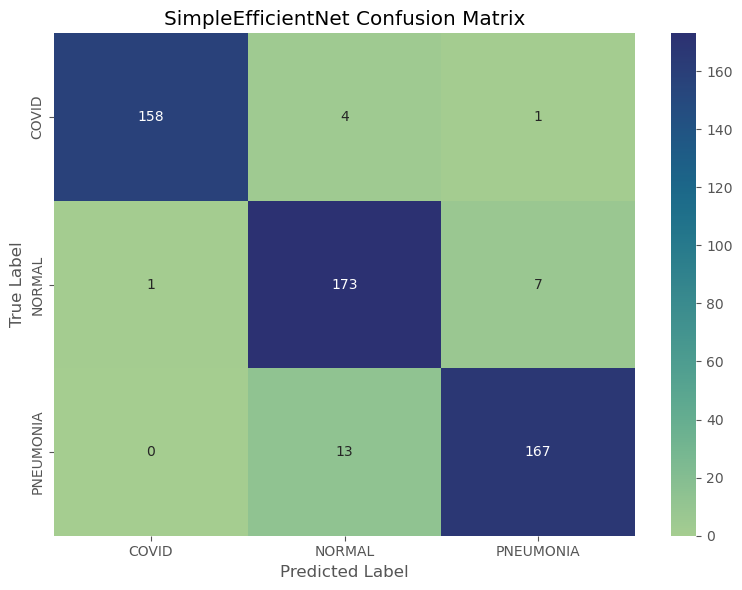

In [108]:
save_path = (
    f"{project_root}/results/{MODEL_NAME}_finetuned_cfm.png"
)
performance(model, test_loader, DEVICE, MODEL_NAME, class_names=CLASSES, save_path=save_path)

In [109]:
history["MODEL_SAVED_PATH"] = model_save_path
# Save history
json_path = os.path.join(
    project_root,
    f"results/{MODEL_NAME}_finetuned_history.json",
)
save_experiment_json(history, json_path)

History saved to d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\results/SimpleEfficientNet_finetuned_history.json


# **4. Advanced Model (Modified EfficientNet for Model Improvement)**

In [72]:
EPOCHS_STAGE_1 = 10  
LR_STAGE_1 = 1e-3  
EPOCHS_STAGE_2 = 20  
LR_STAGE_2 = 1e-5  
PATIENCE = 5
MODEL_NAME = "EfficientNetAdvanced"

In [73]:
from model import EfficientAdvanced

In [74]:
model = EfficientAdvanced(num_classes=len(CLASSES)).to(DEVICE)
torchsummary.summary(model, (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [75]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_recall": [],
    "val_auc": [],
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

### **4.1 Train Head-only first**

In [76]:
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_1)
criterion = nn.CrossEntropyLoss()
MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}.pth"
)
history["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH
early_stopping = EarlyStopping(
    model_checkpoint=MODEL_SAVED_PATH, patience=PATIENCE, mode="max"
)

In [77]:
print(
    f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}"
)

for epoch in range(EPOCHS_STAGE_1):
    # # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)

    should_stop, best_score, best_epoch = early_stopping.should_stop(
        model, optimizer=optimizer, epoch=epoch, score=valid_acc
    )
    if should_stop:
        print(f"Early stopping: Stop at epoch: {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}")
        break

    history["best_accuracy"] = best_score
    history["best_epoch"] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


[1/10] train_acc: 0.8082 - train_loss: 0.5038 - valid_acc: 0.8967 - valid_loss: 0.2787
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 1 - acc: 0.8967



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.47it/s]


[2/10] train_acc: 0.8589 - train_loss: 0.3716 - valid_acc: 0.9025 - valid_loss: 0.2437
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 2 - acc: 0.9025



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.50it/s]


[3/10] train_acc: 0.8780 - train_loss: 0.3312 - valid_acc: 0.9006 - valid_loss: 0.2383
	- [current best] epoch: 2 - acc: 0.9025



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.63it/s]


[4/10] train_acc: 0.8689 - train_loss: 0.3422 - valid_acc: 0.9063 - valid_loss: 0.1965
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 4 - acc: 0.9063



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.54it/s]


[5/10] train_acc: 0.8716 - train_loss: 0.3299 - valid_acc: 0.9216 - valid_loss: 0.2013
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 5 - acc: 0.9216



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


[6/10] train_acc: 0.8692 - train_loss: 0.3353 - valid_acc: 0.9159 - valid_loss: 0.2241
	- [current best] epoch: 5 - acc: 0.9216



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.32it/s]


[7/10] train_acc: 0.8763 - train_loss: 0.3227 - valid_acc: 0.9178 - valid_loss: 0.1948
	- [current best] epoch: 5 - acc: 0.9216



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.41it/s]


[8/10] train_acc: 0.8802 - train_loss: 0.3185 - valid_acc: 0.9197 - valid_loss: 0.1995
	- [current best] epoch: 5 - acc: 0.9216



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


[9/10] train_acc: 0.8778 - train_loss: 0.3205 - valid_acc: 0.9273 - valid_loss: 0.1911
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 9 - acc: 0.9273



Evaluating: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

[10/10] train_acc: 0.8833 - train_loss: 0.3074 - valid_acc: 0.9235 - valid_loss: 0.2052
	- [current best] epoch: 9 - acc: 0.9273



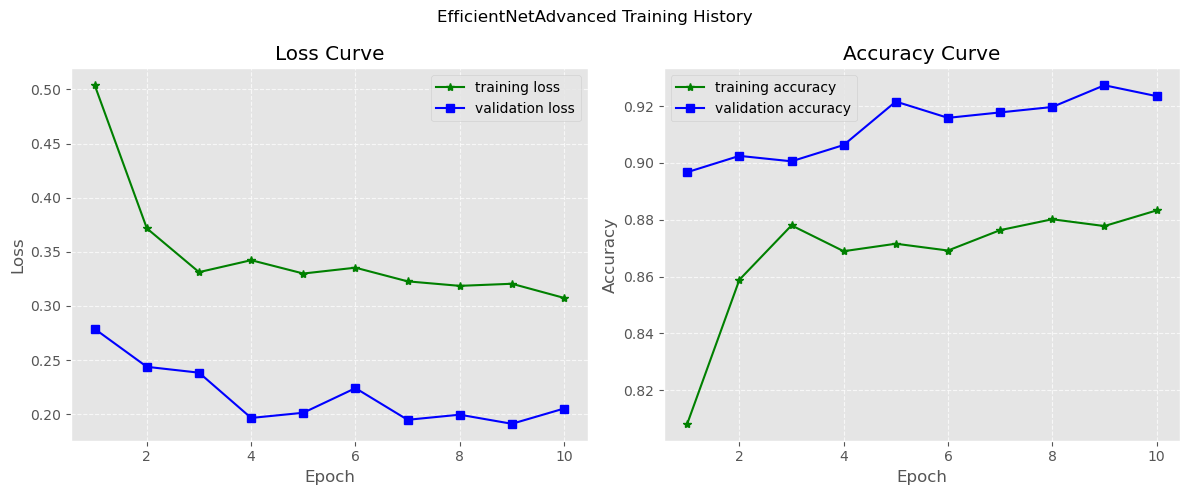

In [78]:
plot_history(history, f"{MODEL_NAME} Training History")

In [79]:
# Load the model again
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 17/17 [00:03<00:00,  4.36it/s]


Accuracy score: 0.9370
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       163
           1       0.90      0.93      0.92       181
           2       0.93      0.93      0.93       180

    accuracy                           0.94       524
   macro avg       0.94      0.94      0.94       524
weighted avg       0.94      0.94      0.94       524



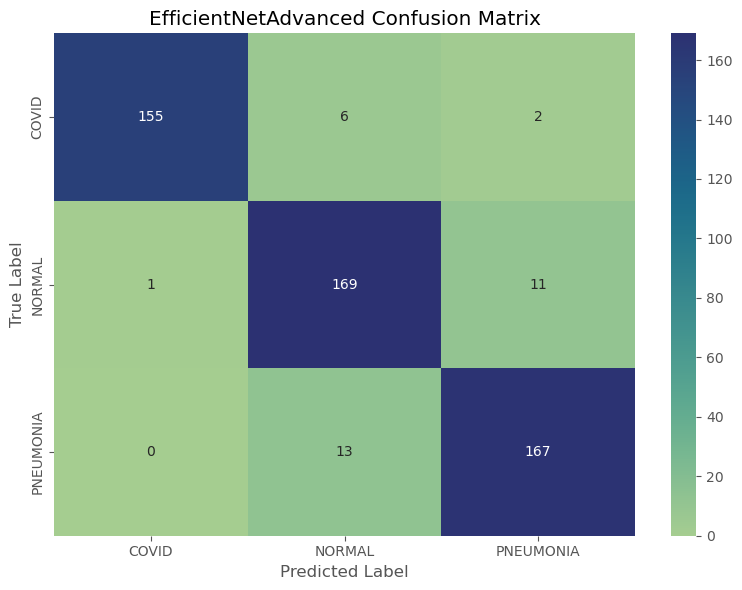

In [80]:
save_path = (
    f"{project_root}/results/{MODEL_NAME}_cfm.png"
)
performance(model, test_loader, DEVICE, MODEL_NAME,class_names=CLASSES, save_path=save_path)

In [81]:
# Save history
json_path = os.path.join(
    project_root,
    f"results/{MODEL_NAME}_history.json",
)
save_experiment_json(history, json_path)

History saved to d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\results/EfficientNetAdvanced_history.json


## **4.2 Fine-tune the Model by Unfreezing Some Layers**

In [82]:
params = list(model.parameters())
print("Number of layers: ", len(params))

Number of layers:  217


In [84]:
num_unfreezed_layers = 50
for param in params[-num_unfreezed_layers:]:
    param.requires_grad = True
torchsummary.summary(model.to(DEVICE), (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [85]:
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_2)
criterion = nn.CrossEntropyLoss()
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_finetuned.pth"
new_early_stopping = EarlyStopping(model_checkpoint=model_save_path, patience=PATIENCE)

In [86]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2


print(
    f"Training configuration for stage 2: LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}"
)
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )

    should_stop, best_score, best_epoch = new_early_stopping.should_stop(
        model, optimizer=optimizer, epoch=epoch, score=valid_acc
    )
    if should_stop:
        print(
            f"Early stopping: Stop at epoch: {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}"
        )
        break
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["best_accuracy"] = best_score
    history["best_epoch"] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Training configuration for stage 2: LR = 1e-05, EPOCHS = 20


Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.07it/s]


[11/30 (Fine-Tune)] train_acc: 0.8768 - train_loss: 0.3190 - valid_acc: 0.9178 - valid_loss: 0.2318
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_EfficientNetAdvanced_finetuned.pth
	- [current best] epoch: 11 - acc: 0.9178



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.34it/s]


[12/30 (Fine-Tune)] train_acc: 0.8919 - train_loss: 0.2872 - valid_acc: 0.9159 - valid_loss: 0.1972
	- [current best] epoch: 11 - acc: 0.9178



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.42it/s]


[13/30 (Fine-Tune)] train_acc: 0.8936 - train_loss: 0.2729 - valid_acc: 0.9197 - valid_loss: 0.2206
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_EfficientNetAdvanced_finetuned.pth
	- [current best] epoch: 13 - acc: 0.9197



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.42it/s]


[14/30 (Fine-Tune)] train_acc: 0.8888 - train_loss: 0.2882 - valid_acc: 0.9331 - valid_loss: 0.1917
Checkpoint saved: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification/model_checkpoints/best_EfficientNetAdvanced_finetuned.pth
	- [current best] epoch: 14 - acc: 0.9331



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.23it/s]


[15/30 (Fine-Tune)] train_acc: 0.8917 - train_loss: 0.2784 - valid_acc: 0.9273 - valid_loss: 0.1707
	- [current best] epoch: 14 - acc: 0.9331



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.08it/s]


[16/30 (Fine-Tune)] train_acc: 0.8974 - train_loss: 0.2672 - valid_acc: 0.9293 - valid_loss: 0.1703
	- [current best] epoch: 14 - acc: 0.9331



Evaluating: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]


[17/30 (Fine-Tune)] train_acc: 0.9041 - train_loss: 0.2606 - valid_acc: 0.9293 - valid_loss: 0.1690
	- [current best] epoch: 14 - acc: 0.9331



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.35it/s]


[18/30 (Fine-Tune)] train_acc: 0.9077 - train_loss: 0.2475 - valid_acc: 0.9273 - valid_loss: 0.1797
	- [current best] epoch: 14 - acc: 0.9331



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.48it/s]

[19/30 (Fine-Tune)] train_acc: 0.9089 - train_loss: 0.2541 - valid_acc: 0.9312 - valid_loss: 0.1617
Early stopping: Stop at epoch: 19 - Best epoch: 14 - Best score: 0.9330783938814532


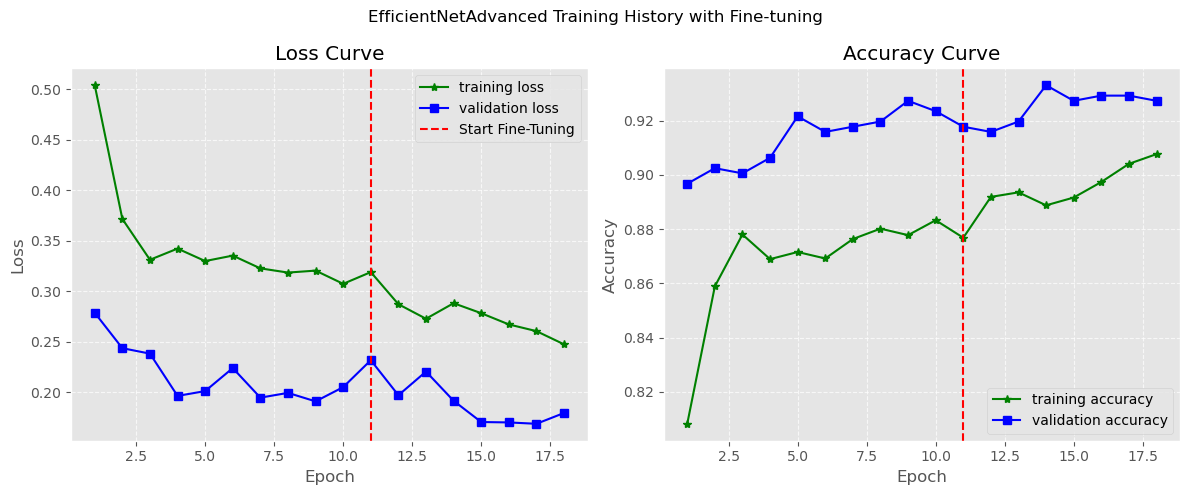

In [87]:
model_saved_name = (
    f"{project_root}/results/{MODEL_NAME}_finetuned"
)
plot_history(
    history,
    f"{MODEL_NAME} Training History with Fine-tuning",
    f"{model_saved_name}.png",
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1,
)

In [88]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 17/17 [00:02<00:00,  5.94it/s]


Accuracy score: 0.9504
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       163
           1       0.91      0.96      0.93       181
           2       0.95      0.93      0.94       180

    accuracy                           0.95       524
   macro avg       0.95      0.95      0.95       524
weighted avg       0.95      0.95      0.95       524



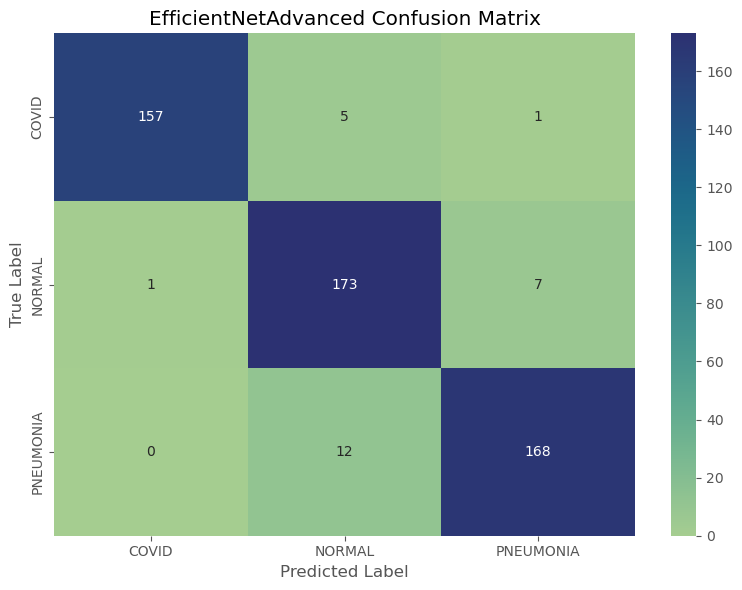

In [89]:
save_path = (
    f"{project_root}/results/{MODEL_NAME}_finetuned_cfm.png"
)
performance(model, test_loader, DEVICE, MODEL_NAME, class_names=CLASSES, save_path=save_path)

In [90]:
history["MODEL_SAVED_PATH"] = model_save_path
# Save history
json_path = os.path.join(
    project_root,
    f"results/{MODEL_NAME}_finetuned_history.json",
)
save_experiment_json(history, json_path)

History saved to d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\DAFLS\final\xray_chest_classification\results/EfficientNetAdvanced_finetuned_history.json


## 5. **Hyperparameter tuning using Ray**

In this section, we will focus on tuning two main things: `batch_size` and `num_unfreezed_layers`

In [68]:
import torch
import ray
from ray import tune
import tempfile
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Checkpoint

In [70]:
train_ref = ray.put(train_dataset)
val_ref = ray.put(val_dataset)

def objective(config):
    batch_size = config["batch_size"]
    num_unfreezed_layers = config["num_unfreezed_layers"]

    train_dataset = ray.get(train_ref)
    val_dataset = ray.get(val_ref)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    model = EfficientAdvanced(len(CLASSES)).to(device=DEVICE)
    # Load the trained head-only model to avoid fine-tuning from scratch
    MODEL_SAVED_PATH = os.path.join(
        project_root, f"model_checkpoints/EfficientNetAdvanced.pth"
    )
    checkpoint = torch.load(MODEL_SAVED_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    params = list(model.parameters())
    for param in params[-num_unfreezed_layers:]:
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(15):
        train_one_epoch(
            model=model, dataloader=train_loader, criterion=criterion, optimizer=optimizer, device=DEVICE
        )  # Train the model
        _, avg_acc = evaluate(model, val_loader, criterion = criterion, device = DEVICE)  # Compute val accuracy

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            torch.save(model.state_dict(), os.path.join(temp_checkpoint_dir, "model.pth"))
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            tune.report({"accuracy": avg_acc, "epoch" : epoch}, checkpoint=checkpoint)  # Report to Tune


search_space = {"batch_size": tune.grid_search([i for i in range(16, 40, 8)]),
                "num_unfreezed_layers": tune.grid_search([30, 90, 150])}


# Add early stopping
asha_scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    grace_period=5,
)
tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
    ),
    param_space=search_space,
)
results = tuner.fit()

(pid=55445) [2025-12-21 10:17:25,817 E 55445 21067228] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
Training:   0%|          | 0/131 [00:00<?, ?it/s]
(pid=55458) [2025-12-21 10:17:27,730 E 55458 21067450] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 8x across cluster]
Training:  95%|█████████▌| 249/262 [02:04<00:05,  2.25it/s, loss=0.421]
(objective pid=55447) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/mac/ray_results/objective_2025-12-21_10-16-53/objective_7f6a6_00002_2_batch_size=32,num_unfreezed_layers=30_2025-12-21_10-16-53/checkpoint_000000)
Training:  99%|█████████▉| 260/262 [02:10<00:01, 

In [73]:
print("Best config is:", results.get_best_result("accuracy", mode="max"))

Best config is: Result(
  metrics={'accuracy': 0.9407265774378585, 'epoch': 14},
  path='/Users/mac/ray_results/objective_2025-12-21_10-16-53/objective_7f6a6_00005_5_batch_size=32,num_unfreezed_layers=90_2025-12-21_10-16-53',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/Users/mac/ray_results/objective_2025-12-21_10-16-53/objective_7f6a6_00005_5_batch_size=32,num_unfreezed_layers=90_2025-12-21_10-16-53/checkpoint_000014)
)


In [75]:
best_result = results.get_best_result("accuracy", mode='max')

with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

In [76]:
model = EfficientAdvanced(len(CLASSES))
model.load_state_dict(state_dict)

<All keys matched successfully>

Getting predictions:   0%|          | 0/17 [00:00<?, ?it/s]/Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Getting predictions: 100%|██████████| 17/17 [00:03<00:00,  4.62it/s]


Accuracy score: 0.9523
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       163
           1       0.92      0.94      0.93       181
           2       0.96      0.94      0.95       180

    accuracy                           0.95       524
   macro avg       0.95      0.95      0.95       524
weighted avg       0.95      0.95      0.95       524



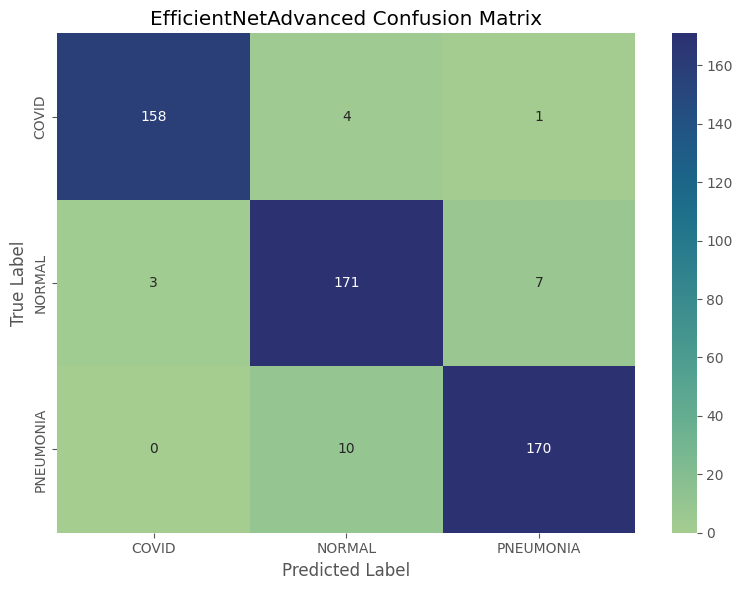

In [77]:
model = model.to(DEVICE)
save_path = f"{project_root}/results/{MODEL_NAME}_finetuned_hyperparameter_tuning_cfm.png"
performance(
    model, test_loader, DEVICE, MODEL_NAME, class_names=CLASSES, save_path=save_path
)

In [78]:
# Save in real model weight
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_finetuned_hyperparameter_tuned.pth"
checkpoint = {"state_dict": state_dict}
torch.save(checkpoint, model_save_path)

# **6. Model Evaluation with Grad-Cam**